# POPULARITY OVERTIME

#### was done : (only on finished paths)
- popularity of articles over years
    - using standard deviation of number of clics the article overtime
    - using absolute difference of number of clics on the article between adjacent dates 
- popularity of articles over months
    - using standard deviation of number of clics the article overtime
    - using absolute difference of number of clics on the article between adjacent dates 
- popularity of categories over months 
    - using std of the ratio of # paths containing the category/ #path that dont
    - same ratio but normalized by the total number of paths containing the category

#### sugestions 
- check if spikes are due to events
- check if spikes are due to the fact targets were randomly more on a certain subject at certain moments
-  maybe find a way to detect variability on categories/articles more interesting than just the top 5, there might be an increase that is less visible but more clearly correlated to world news on a specific topic that made people have more knoledge on this subject and use it in paths





In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os


In [3]:
# Define a tuple of file paths and column names
paths_and_graphs_path = 'data/paths-and-graph/'

files_and_columns = (
    (os.path.join(paths_and_graphs_path, 'paths_finished.tsv'), ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']),
    (os.path.join(paths_and_graphs_path, 'paths_unfinished.tsv'), ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']),
    (os.path.join(paths_and_graphs_path, 'articles.tsv'), ['article']),
    (os.path.join(paths_and_graphs_path, 'categories.tsv'), ['article', 'category'])
)

def read_files(file_tuples):
    dataframes = []
    for path, column_names in file_tuples:
        df = pd.read_csv(path, sep='\t', comment='#', names=column_names, header=None)
        dataframes.append(df)
    return dataframes

paths_finished, paths_unfinished, articles, categories  = read_files(files_and_columns)

##### Working of finished paths : remove 1st article, targed and '<'s

In [4]:
paths_finished['year'] = pd.to_datetime(paths_finished['timestamp'], unit='s').dt.year #convert uxix timestamp 

#remove 1st, last and <'s
paths_finished['intermediate_articles'] = paths_finished['path'].apply(lambda x: [article for article in x.split(';')[1:-1] if article != '<'])

# Articles popularity

## Popularité des articles au cours des années : STD


In [ ]:
# Count occurrences of each article in the year, normalize by ocurence in all years confounded
yearly_article_counts = {}
for year, group in paths_finished.groupby('year'):
    # Flatten the list of intermediate articles for each row in the group (all entries for that year)
    articles = [article for sublist in group['intermediate_articles'] for article in sublist]
    # Count occurrences of each article in the year and store in the dictionary
    yearly_article_counts[year] = Counter(articles)
    
yearly_article_counts = pd.DataFrame(yearly_article_counts).fillna(0).astype(int)
total_articles_per_year = yearly_article_counts.sum(axis=0)
normalized_yearly_article_counts = yearly_article_counts.div(total_articles_per_year, axis=1)

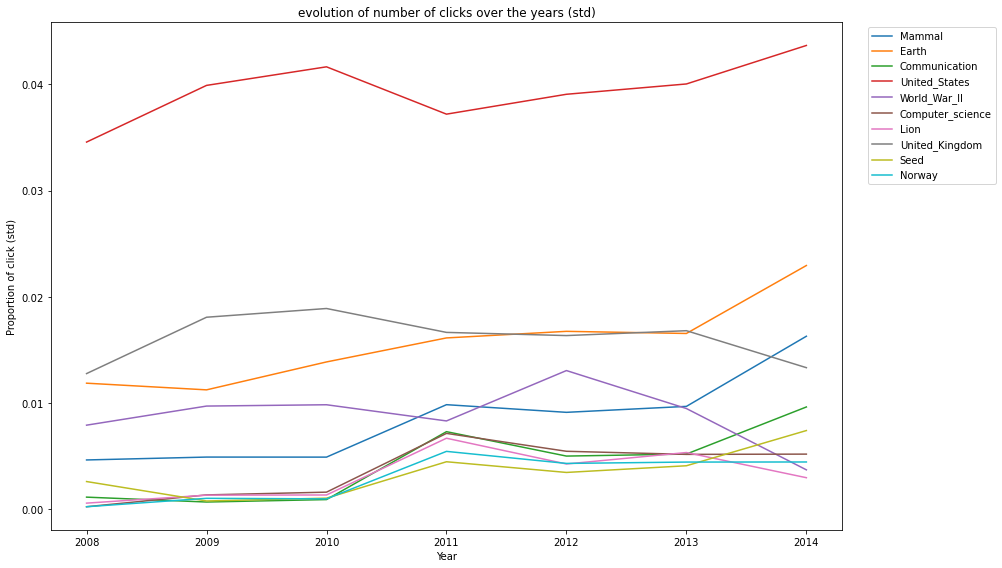

In [6]:
#normalize and chose most variable articles to plot
popularity_std = normalized_yearly_article_counts.std(axis=1)
most_variable_articles = popularity_std.nlargest(10).index

plt.figure(figsize=(14, 8))
for article in most_variable_articles:
    plt.plot(normalized_yearly_article_counts.columns, normalized_yearly_article_counts.loc[article], label=article)

plt.xlabel('Year')
plt.ylabel('Proportion of click (std)')
plt.title('evolution of number of clicks over the years (std)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1) 
plt.tight_layout()

## Popularité des articles au cours des années : absolute difference of pop between adjacent years 

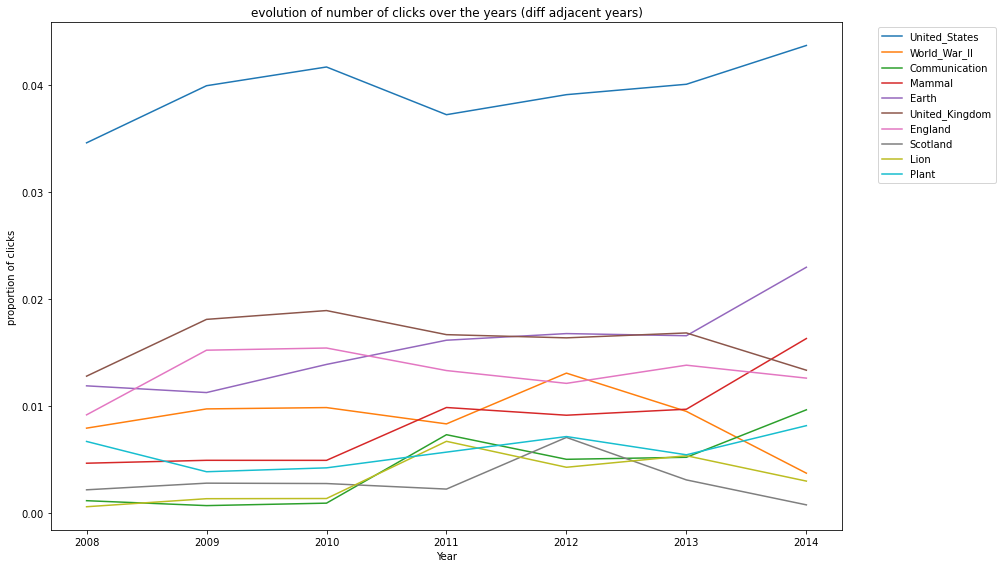

In [7]:
# .diff() differences in popularity between consecutive years
yearly_diffs = normalized_yearly_article_counts.diff(axis=1).abs()

# cumulative variation for each article : chose top 10 to print
diff_sum = yearly_diffs.sum(axis=1)
most_diff_articles = diff_sum.nlargest(10).index

plt.figure(figsize=(14, 8))
for article in most_diff_articles:
    plt.plot(normalized_yearly_article_counts.columns, normalized_yearly_article_counts.loc[article], label=article)
plt.xlabel('Year')
plt.ylabel('proportion of clicks')
plt.title('evolution of number of clicks over the years (diff adjacent years)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)  
plt.tight_layout()

## same au cours des mois 

In [8]:
# Convert the timestamp to datetime and extract both year and month
paths_finished['year_month'] = pd.to_datetime(paths_finished['timestamp'], unit='s').dt.to_period('M')

# Remove first, last, and '<' from the intermediate articles
paths_finished['intermediate_articles'] = paths_finished['path'].apply(lambda x: [article for article in x.split(';')[1:-1] if article != '<'])

# Count occurrences of each article in each month, normalize by occurrence across all months
monthly_article_counts = {}
for year_month, group in paths_finished.groupby('year_month'):
    articles = [article for sublist in group['intermediate_articles'] for article in sublist]
    # Count occurrences of each article in the month and store in the dictionary
    monthly_article_counts[year_month] = Counter(articles)
monthly_article_counts = pd.DataFrame(monthly_article_counts).fillna(0).astype(int)

# Normalize the monthly article counts by dividing by total articles per month
total_articles_per_month = monthly_article_counts.sum(axis=0)
normalized_monthly_article_counts = monthly_article_counts.div(total_articles_per_month, axis=1)

articles, months, STD

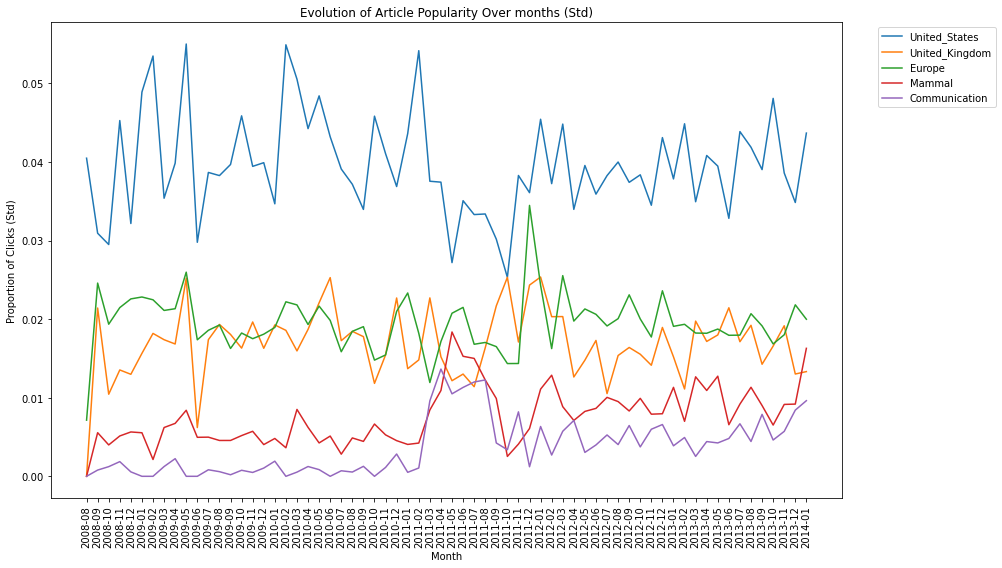

In [9]:
# Calculate the standard deviation for each article across months
popularity_std = normalized_monthly_article_counts.std(axis=1)

# Choose the top 5 articles with the highest standard deviation (most variable)
most_variable_articles = popularity_std.nlargest(5).index

# Create the plot
plt.figure(figsize=(14, 8))
for article in most_variable_articles:
    plt.plot(normalized_monthly_article_counts.columns.astype(str), normalized_monthly_article_counts.loc[article], label=article)

plt.xlabel('Month')
plt.ylabel('Proportion of Clicks (Std)')
plt.title('Evolution of Article Popularity Over months (Std)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1) 
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()


articles, months, adjacent months difference 

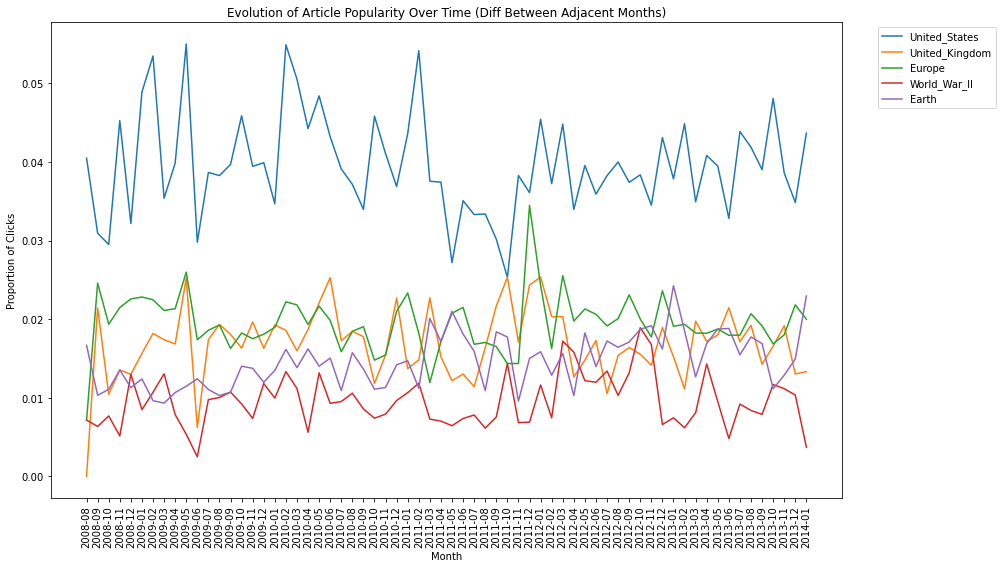

In [10]:
# Calculate the difference in popularity between consecutive months
monthly_diffs = normalized_monthly_article_counts.diff(axis=1).abs()

# Calculate the cumulative variation (sum of differences) for each article
diff_sum = monthly_diffs.sum(axis=1)

# Choose the top 5 articles with the highest cumulative variation
most_diff_articles = diff_sum.nlargest(5).index

# Create the plot
plt.figure(figsize=(14, 8))
for article in most_diff_articles:
    plt.plot(normalized_monthly_article_counts.columns.astype(str), normalized_monthly_article_counts.loc[article], label=article)

plt.xlabel('Month')
plt.ylabel('Proportion of Clicks')
plt.title('Evolution of Article Popularity Over Time (Diff Between Adjacent Months)')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)  
plt.xticks(rotation=90)  # Rotate month labels for better readability
plt.tight_layout()

plt.show()


# Categories popularity

## ratio of paths containing a category vs not over time 
evolution over time of the ratio of paths that contain at least one article from a specified category compared to those that do not 

In [11]:
# get a list of all categories 
# remove "subject." and split by dots
categories['subcategory_parts'] = categories['category'].str.replace('subject.', '', regex=False).str.split('.')
unique_subcategories = pd.Series([part for parts in categories['subcategory_parts'] for part in parts]).unique().tolist()

print(unique_subcategories)


['History', 'British_History', 'British_History_1500_and_before_including_Roman_Britain', 'People', 'Historical_figures', 'Countries', 'Geography', 'European_Geography', 'European_Countries', 'Artists', 'Business_Studies', 'Currency', 'General_history', 'Military_History_and_War', 'Science', 'Physics', 'Space_Astronomy', 'Everyday_life', 'Sports_events', 'Storms', 'Recent_History', 'Geology_and_geophysics', 'Natural_Disasters', 'Design_and_Technology', 'Railway_transport', 'Sports_and_games_people', 'Biology', 'Health_and_medicine', 'Music', 'Performers_and_composers', 'IT', 'Computing_hardware_and_infrastructure', 'Companies', 'General_Physics', 'Language_and_literature', 'Novels', 'Musical_genres_styles_eras_and_events', 'Mammals', 'Plants', 'Mathematics', 'Geography_of_the_Middle_East', 'Ancient_History_Classical_History_and_Mythology', 'British_History_15001750', 'Religion', 'Religious_movements_traditions_and_organizations', 'Theatre', 'Geographers_and_explorers', 'Geography_of_Gr

In [12]:
import datetime
paths_finished['intermediate_articles']
# add date column in paths_finished, sort by date 
paths_finished["date"] = paths_finished.timestamp.apply(lambda d: datetime.datetime.utcfromtimestamp(d).strftime('%Y-%m'))
paths_finished = paths_finished.sort_values(by="date", ascending=True)

all_ratios = pd.DataFrame()
# calculate popularity ratios
for category in unique_subcategories:
    # list of all articles containing the current category
    articles_containing_categ = categories[categories["category"].str.contains(category)]["article"]
    
    # add boolean column for the current category
    paths_finished["theme"] = paths_finished["path"].apply(lambda x: any(article in articles_containing_categ.values for article in x.split(";")))
    
    # group paths of the same date having the category, and not: count size of each group: 
    # aka nb of path with and nb of paths without the category for each date (column count of df grouped)
    grouped = paths_finished.groupby(["date", "theme"]).size().reset_index(name='count')
    
    # ensure all months has a count (for both having and not the category)
    unique_dates = grouped['date'].unique()
    for date in unique_dates:
        if not ((grouped['date'] == date) & (grouped['theme'] == True)).any():
            grouped = pd.concat([grouped, pd.DataFrame({'date': [date], 'theme': [True], 'count': [0]})], ignore_index=True)
    
    # Sort by date
    grouped = grouped.sort_values(by='date').reset_index(drop=True)
    
    # ratio of paths containing articles from a specific category (theme=True) to those that do not (theme=False) for each date
    # assigns a category label to each row
    grouped["ratio"] = grouped.apply(lambda x: x["count"] / grouped[(grouped["date"] == x["date"]) & (grouped["theme"] == False)]["count"].values[0], axis=1)
    grouped["category"] = category
    
    # Store results for each category
    all_ratios = pd.concat([all_ratios, grouped[grouped["theme"] == True][["date", "category", "ratio"]]])


In [14]:
# top 5 categories that have the biggest variation of ratio over time 
top_5_categories = all_ratios.groupby("category")["ratio"].std().nlargest(5).index #list of 5 categories
top_5_ratios = all_ratios[all_ratios["category"].isin(top_5_categories)] #filter all ratio to inclide 5 categories

top_5_ratios

,date,category,ratio
1,2008-08,People,0.711538
3,2008-09,People,0.426009
5,2008-10,People,0.423729
7,2008-11,People,0.388406
9,2008-12,People,0.524528
...,...,...,...
123,2013-09,Biology,0.541237
125,2013-10,Biology,0.595506
127,2013-11,Biology,0.524809
129,2013-12,Biology,0.589041


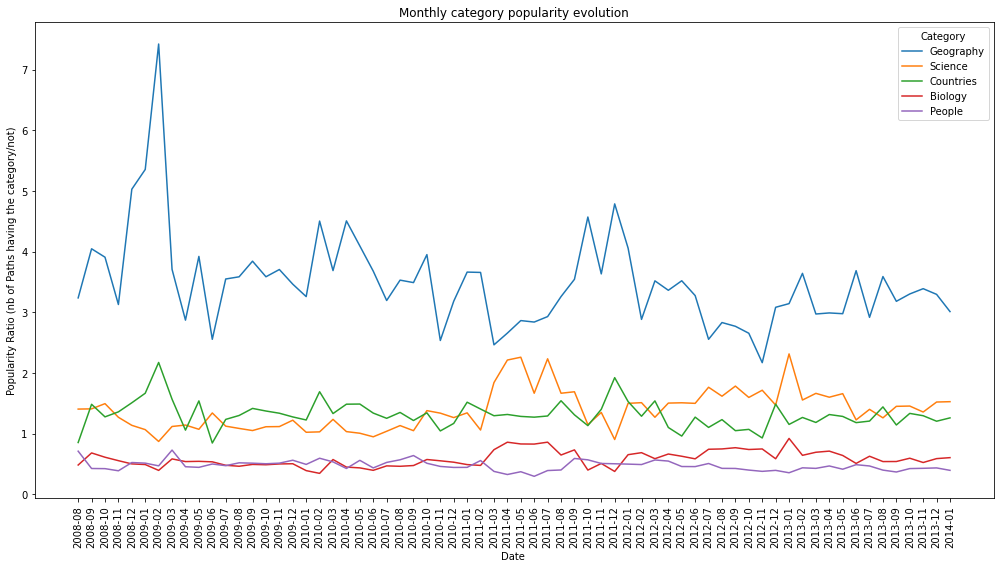

In [15]:
plt.figure(figsize=(14, 8))
for category in top_5_categories:
    category_data = top_5_ratios[top_5_ratios['category'] == category]
    plt.plot(category_data['date'], category_data['ratio'], label=category)

plt.xlabel('Date ')
plt.ylabel('Popularity Ratio (nb of Paths having the category/not)')
plt.title('Monthly category popularity evolution')
plt.legend(title="Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Normalizing ratio by average nb of paths containing category 

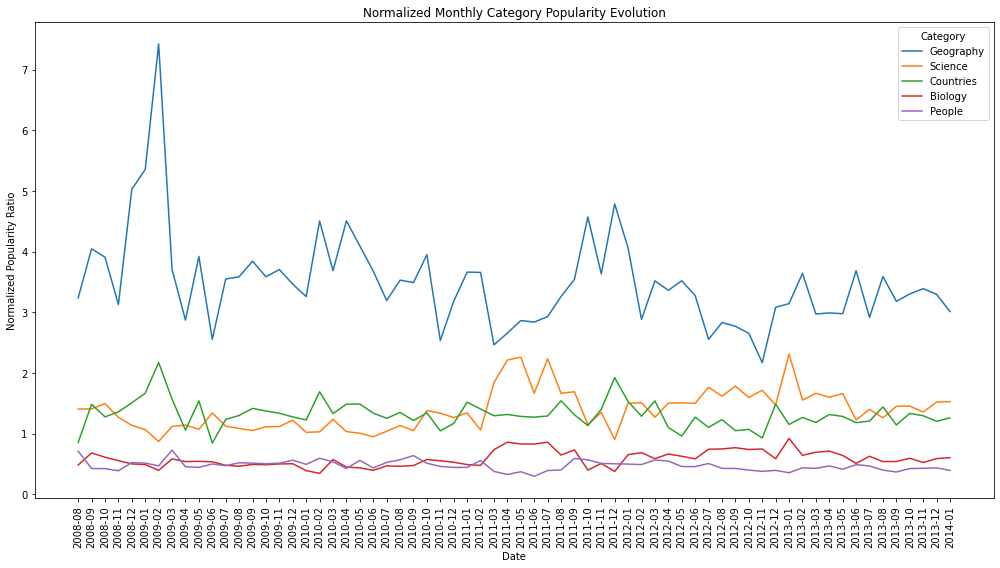

In [16]:
# Calculate the average number of paths for each category from the 'categories' DataFrame
average_category_paths = categories.groupby("category").size()

# Calculate the popularity ratio for each category
all_ratios = pd.DataFrame()
for category in unique_subcategories:
    # List of all articles containing the current category
    articles_containing_categ = categories[categories["category"].str.contains(category)]["article"]
    
    # Add boolean column for the current category
    paths_finished["theme"] = paths_finished["path"].apply(
        lambda x: any(article in articles_containing_categ.values for article in x.split(";"))
    )
    
    # Group paths by date and whether they contain the category (theme=True/False)
    grouped = paths_finished.groupby(["date", "theme"]).size().reset_index(name='count')
    
    # Ensure all months have a count (for both having and not the category)
    unique_dates = grouped['date'].unique()
    for date in unique_dates:
        if not ((grouped['date'] == date) & (grouped['theme'] == True)).any():
            grouped = pd.concat([grouped, pd.DataFrame({'date': [date], 'theme': [True], 'count': [0]})], ignore_index=True)
    
    # Sort by date
    grouped = grouped.sort_values(by='date').reset_index(drop=True)
    
    # Calculate the ratio for each category
    grouped["ratio"] = grouped.apply(
        lambda x: x["count"] / grouped[(grouped["date"] == x["date"]) & (grouped["theme"] == False)]["count"].values[0],
        axis=1
    )
    
    # Normalize the ratio by dividing by the average number of paths for the category
    grouped["normalized_ratio"] = grouped["ratio"] / average_category_paths.get(category, 1)
    
    # Assign the category label
    grouped["category"] = category
    
    # Store the results for the category
    all_ratios = pd.concat([all_ratios, grouped[grouped["theme"] == True][["date", "category", "normalized_ratio"]]])

# Select the top 5 categories with the most variable normalized popularity ratios
top_5_categories = all_ratios.groupby("category")["normalized_ratio"].std().nlargest(5).index
top_5_ratios = all_ratios[all_ratios["category"].isin(top_5_categories)]

# Now you can plot the normalized ratio
plt.figure(figsize=(14, 8))
for category in top_5_categories:
    category_data = top_5_ratios[top_5_ratios['category'] == category]
    plt.plot(category_data['date'], category_data['normalized_ratio'], label=category)

plt.xlabel('Date')
plt.ylabel('Normalized Popularity Ratio')
plt.title('Normalized Monthly Category Popularity Evolution')
plt.legend(title="Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## interesting datasets : archive of usa news 
https://www.livescience.com/archive/2011/05


https://www.infoplease.com/current-events/2011/may-2011-current-events-us-news